# Example of multi-criteria decision-making (MCDM)

This example chooses a method of travel from three possible modes.  We will follow the qualitative scoring technique from Mistree, F., Lewis, K., Stonis, L., “Selection in the Conceptual Design of Aircraft”, AIAA Journal, Paper no. AIAA-94-4382, 1994.  (Available at http://arc.aiaa.org/doi/pdf/10.2514/6.1994-4382).

The method is implemented in the simple mcdm.py library.  First, we set up a new Mcdm object and tell it the options we will be choosing between.  We can view the Mcdm matrix as a table, which is blank to begin with.

In [1]:
from mcdm import Mcdm
travel=Mcdm(('Car','Train','Plane'))
travel.to_html()

Option
Car
Train
Plane


Time to set some scores.  We will consider five criteria:
* Env: the cost to the environment
* Speed
* Price
* Work: how much work we can get done during the trip
* Conv: how convenient the arrangements are, e.g. are there long transfers

To begin, we'll take the Car option as the baseline and score the other two, starting with the Train option.

In [2]:
travel.set_score('Train','Env',1)
travel.set_score('Train','Speed',1)
travel.set_score('Train','Price',-1)
travel.set_score('Train','Work',1)
travel.set_score('Train','Conv',-1)
travel.to_html()

Option,Env,Speed,Price,Work,Conv
Car,0.000,0.000,0.000,0.000,0.000
Train,1.000,1.000,-1.000,1.000,-1.000
Plane,0.000,0.000,0.000,0.000,0.000


And now repeat with the Plane option.  Note that I never had to explicitly list the criteria: instead, they are added as columns when I provide the relevant scores.  I'm using a simple scoring scheme:
* +2 option is much better than baseline
* +1 option is somewhat better than baseline
* 0 option indistinguishable from baseline
* -1 option is somewhat worse than baseline
* -2 option is far worse than baseline

In [3]:
travel.set_score('Plane','Env',-1)
travel.set_score('Plane','Speed',2)
travel.set_score('Plane','Price',-2)
travel.set_score('Plane','Work',1)
travel.set_score('Plane','Conv',-2)
travel.to_html()

Option,Env,Speed,Price,Work,Conv
Car,0.000,0.000,0.000,0.000,0.000
Train,1.000,1.000,-1.000,1.000,-1.000
Plane,-1.000,2.000,-2.000,1.000,-2.000


We can look at a plot at any stage.  If the result was obvious from this, great - but it's not, so we'll press on with the method.

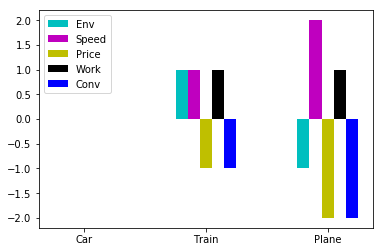

In [4]:
travel.plot()

## Multiple baselines

For fair and comprehensive comparison, we must repeat using each option as the baseline.  Using the copy method with the reset_scores option, I can easily create new blank tables for the same decision problem.

In [5]:
travel_train_base = travel.copy(reset_scores=True)
travel_train_base.to_html()

Option,Env,Speed,Price,Work,Conv
Car,0.000,0.000,0.000,0.000,0.000
Train,0.000,0.000,0.000,0.000,0.000
Plane,0.000,0.000,0.000,0.000,0.000


This time, we'll use the Train as the baseline and score the Car and the Plane against it.

In [6]:
travel_train_base.set_score('Car','Work',-1)
travel_train_base.set_score('Car','Conv',1)
travel_train_base.set_score('Car','Speed',-1)
travel_train_base.set_score('Car','Env',-1)
travel_train_base.set_score('Car','Price',1)
travel_train_base.set_score('Plane','Work',-1)
travel_train_base.set_score('Plane','Conv',-1)
travel_train_base.set_score('Plane','Speed',1)
travel_train_base.set_score('Plane','Env',-1)
travel_train_base.set_score('Plane','Price',-1)
travel_train_base.to_html()

Option,Env,Speed,Price,Work,Conv
Car,-1.000,-1.000,1.000,-1.000,1.000
Train,0.000,0.000,0.000,0.000,0.000
Plane,-1.000,1.000,-1.000,-1.000,-1.000


Finally, use the plane as baseline.  To save typing, we can use the shortcut set_scores_dict method to set multiple scores at once using a Python dictionary.

Thinking about it, these final scores are potentially redundant.  We've scored the plane against the car when the car was the baseline and the plane against the train when the train was the baseline, so all these comparisons have been done.  However, others have been done twice (car vs train, for example), so we need to do them all for fairness when we add them up later.  Also, there's no way at the moment of checking for consistency between two goes at the same comparison.  Stay alert!

In [7]:
travel_plane_base = travel.copy(reset_scores=True)
travel_plane_base.set_scores_dict({('Car','Work'):-1,
                                   ('Car','Speed'):-1,
                                   ('Car','Env'):1,
                                   ('Car','Conv'):2,
                                   ('Car','Price'):2})
travel_plane_base.set_scores_dict({('Train','Work'):1,
                                   ('Train','Speed'):-1,
                                   ('Train','Env'):2,
                                   ('Train','Conv'):1,
                                   ('Train','Price'):1})
travel_plane_base.to_html()

Option,Env,Speed,Price,Work,Conv
Car,1.000,-1.000,2.000,-1.000,2.000
Train,2.000,-1.000,1.000,1.000,1.000
Plane,0.000,0.000,0.000,0.000,0.000


Now we can add the three comparisons together.  The Mcdm class overloads the "+" operator so we can just add them up in one line to sum all the scores.  All well and good, but even the plot doesn't offer an easy decision yet.

In [8]:
travel_all_base = travel + travel_train_base + travel_plane_base
travel_all_base.to_html()

Option,Env,Speed,Price,Work,Conv
Car,0.000,-2.000,3.000,-2.000,3.000
Train,3.000,0.000,0.000,2.000,0.000
Plane,-2.000,3.000,-3.000,0.000,-3.000


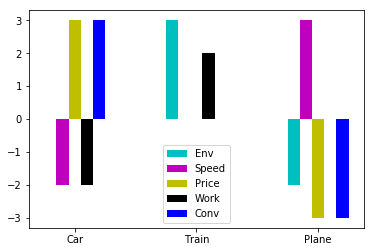

In [9]:
travel_all_base.plot()

## Weighting criteria

So far, we've not attempted to capture any idea of relative importance between the different criteria.  If we could, we might be able to collapse to a single score and make a decision.  Before we can combine scores, we rescale them all to between 0 and 1.

In [10]:
travel_all_01=travel_all_base.rescale()
travel_all_01.to_html()

Option,Env,Speed,Price,Work,Conv
Car,0.500,0.167,1.000,0.167,1.000
Train,1.000,0.500,0.500,0.833,0.500
Plane,0.167,1.000,0.000,0.500,0.000


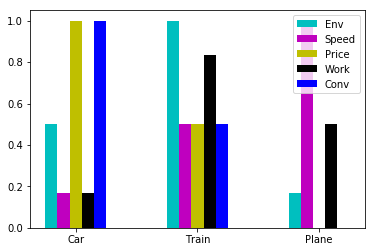

In [11]:
travel_all_01.plot()

Look closely and check that this is the same as the previous plot, but with the y-axis shifted and at a different scale, as we would expect.

Now, we propose a weighting vector, and use that to include a new 'Intuition' column in the decision matrix.  We can use the select_criteria method to focus on it.  It looks like the train wins, but it's tight.

In [12]:
travel_all_01.weight_criteria('Intuition',{'Work':0.3,
                                           'Price':0.2,
                                           'Conv':0.3,
                                          'Env':0.1,
                                          'Speed':0.1})
travel_all_01.to_html()

Option,Env,Speed,Price,Work,Conv,Intuition
Car,0.500,0.167,1.000,0.167,1.000,0.617
Train,1.000,0.500,0.500,0.833,0.500,0.650
Plane,0.167,1.000,0.000,0.500,0.000,0.267


In [13]:
travel_all_01.select_criteria(['Intuition']).to_html()

Option,Intuition
Car,0.617
Train,0.650
Plane,0.267


## Trying Different Weights

Unstaisfied by the previous result, we propose a systematic trial of different weights.  Each weight trial will emphasize one criteria twice as much as all others: 
$$w_j = \left(\frac{1}{N_{criteria}+1},..,\frac{1}{N_{criteria}+1},\frac{2}{N_{criteria}+1},\frac{1}{N_{criteria}+1},..,\frac{1}{N_{criteria}+1}\right)$$.
Happily, there's a weight_mixture method that will automate this process, producing five new columns for each of our five criteria to be emphasized.

In [14]:
travel_all_01.weight_mixture(['Work','Speed','Price','Conv','Env'])
travel_all_01.to_html()

Option,Env,Speed,Price,Work,Conv,Intuition,Work_High,Speed_High,Price_High,Conv_High,Env_High
Car,0.500,0.167,1.000,0.167,1.000,0.617,0.500,0.500,0.639,0.639,0.556
Train,1.000,0.500,0.500,0.833,0.500,0.650,0.694,0.639,0.639,0.639,0.722
Plane,0.167,1.000,0.000,0.500,0.000,0.267,0.361,0.444,0.278,0.278,0.306


Let's just pull out the new ones, plus the Intuition column, and compare them.

In [15]:
travel_all_01.select_criteria(['{}_High'.format(cri) for cri in ['Work','Speed','Price','Conv','Env']]
                                + ['Intuition']).to_html()

Option,Work_High,Speed_High,Price_High,Conv_High,Env_High,Intuition
Car,0.500,0.500,0.639,0.639,0.556,0.617
Train,0.694,0.639,0.639,0.639,0.722,0.650
Plane,0.361,0.444,0.278,0.278,0.306,0.267


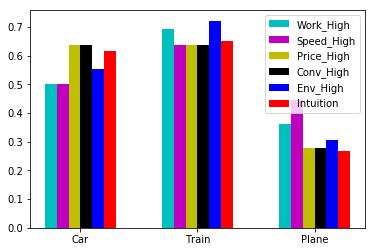

In [16]:
travel_all_01.select_criteria(['{}_High'.format(cri) for cri in ['Work','Speed','Price','Conv','Env']]
                                + ['Intuition']).plot()

Finally we have an answer: the train wins, because it's quite robust to changes in relative importance of criteria (spread of the bars is small) and it does better on average than the others.  The car is a reasonably close second.

## Cautionary note

Of course, this method is ripe for 'Garbage-In-Garbage-Out'.  While the maths and the method are cute, don't let them distract from where the important work is done:
* the selection of the criteria
* the scoring of the alternatives